# 📐 自动识别通道线与收敛三角形
本 Notebook 使用 yfinance 获取股票数据，自动检测局部拐点，绘制上下通道线，并判断是否存在收敛三角形形态（类似 TradingView 的自动分析）。

In [22]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial Unicode MS'
plt.rcParams['axes.unicode_minus'] = False
from scipy.signal import argrelextrema
from sklearn.linear_model import LinearRegression
import matplotlib.dates as mdates

In [23]:
# 获取股票数据
ticker = 'TSLA'
df = yf.download(ticker, period='6mo', interval='1d')
df = df.dropna().reset_index()
price = df['Close'].values

/var/folders/4y/thfdflqj5dq5h4jky3shnl3r0000gn/T/ipykernel_19549/8556860.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period='6mo', interval='1d')
[*********************100%***********************]  1 of 1 completed


In [24]:
# 找到局部极大值和极小值
local_max_idx = argrelextrema(price, np.greater, order=5)[0]
local_min_idx = argrelextrema(price, np.less, order=5)[0]

In [25]:
# 用线性回归拟合上轨（高点）和下轨（低点）
X_max = local_max_idx.reshape(-1, 1)
y_max = price[local_max_idx]
model_resist = LinearRegression().fit(X_max, y_max)
resist_line = model_resist.predict(np.arange(len(df)).reshape(-1, 1))

X_min = local_min_idx.reshape(-1, 1)
y_min = price[local_min_idx]
model_support = LinearRegression().fit(X_min, y_min)
support_line = model_support.predict(np.arange(len(df)).reshape(-1, 1))

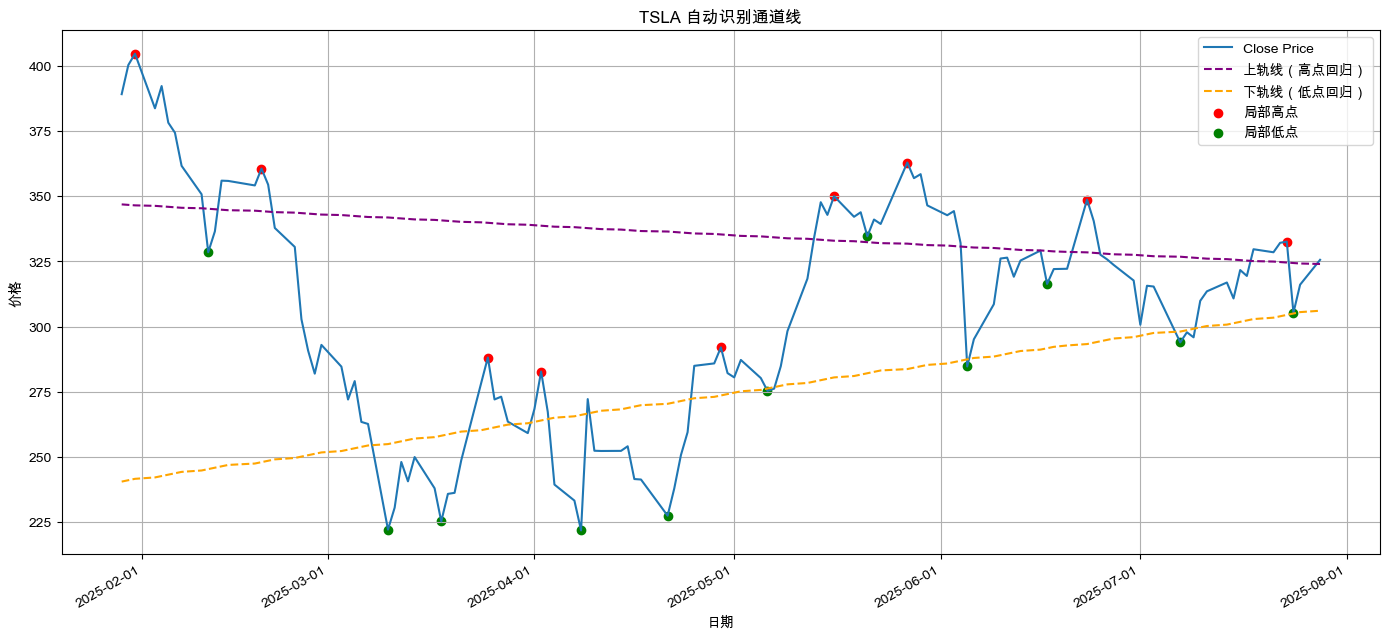

In [26]:
# 可视化收盘价和通道线
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label='Close Price')
plt.plot(df['Date'], resist_line, '--', color='purple', label='上轨线（高点回归）')
plt.plot(df['Date'], support_line, '--', color='orange', label='下轨线（低点回归）')
plt.scatter(df['Date'].iloc[local_max_idx], price[local_max_idx], color='red', label='局部高点')
plt.scatter(df['Date'].iloc[local_min_idx], price[local_min_idx], color='green', label='局部低点')
plt.title(f'{ticker} 自动识别通道线')
plt.xlabel('日期')
plt.ylabel('价格')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.show()

In [27]:
# 判断是否存在收敛三角形（高点趋势向下，低点趋势向上）
N = 4  # 最近N个高点和低点
slope_resist = np.polyfit(local_max_idx[-N:], price[local_max_idx[-N:]], 1)[0]
slope_support = np.polyfit(local_min_idx[-N:], price[local_min_idx[-N:]], 1)[0]

if slope_resist < 0 and slope_support > 0:
    print("🔺 检测到收敛三角形形态！")
else:
    print("⭕ 暂未检测到收敛三角形")

🔺 检测到收敛三角形形态！


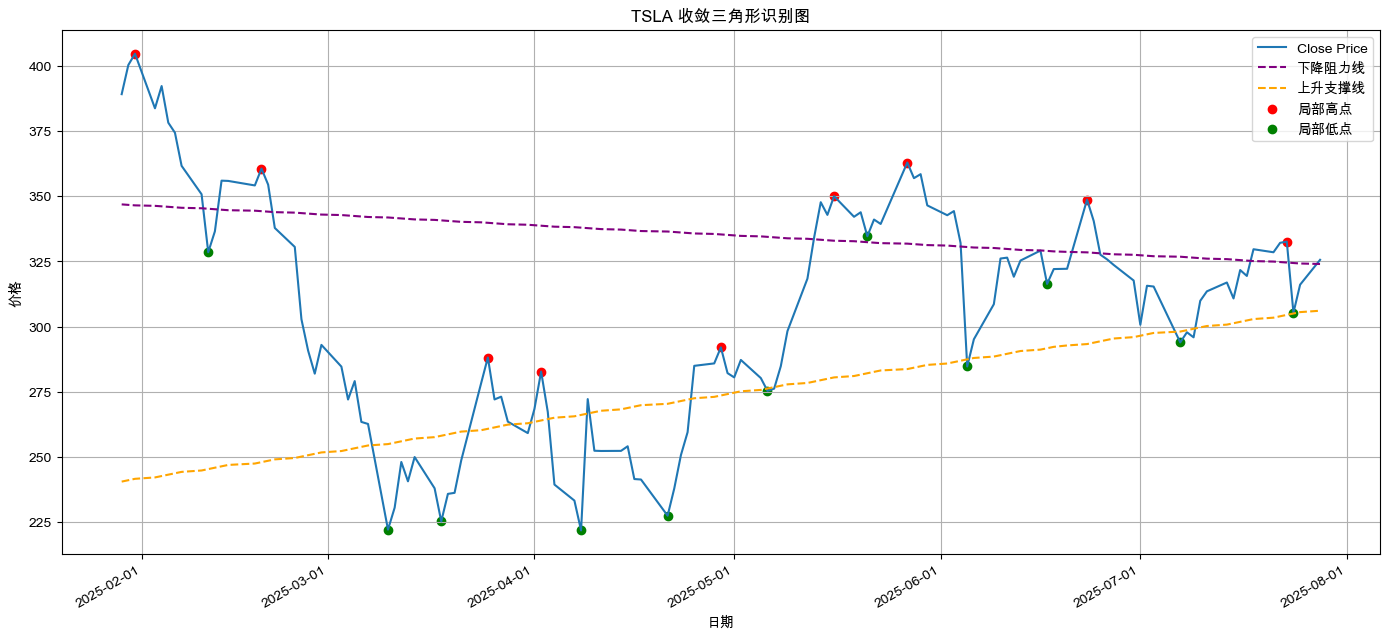

In [28]:
# 如果识别到收敛三角形，绘制专属图形
if slope_resist < 0 and slope_support > 0:
    plt.figure(figsize=(14, 7))
    plt.plot(df['Date'], df['Close'], label='Close Price')
    plt.plot(df['Date'], resist_line, '--', color='purple', label='下降阻力线')
    plt.plot(df['Date'], support_line, '--', color='orange', label='上升支撑线')
    plt.scatter(df['Date'].iloc[local_max_idx], price[local_max_idx], color='red', label='局部高点')
    plt.scatter(df['Date'].iloc[local_min_idx], price[local_min_idx], color='green', label='局部低点')
    plt.title(f'{ticker} 收敛三角形识别图')
    plt.xlabel('日期')
    plt.ylabel('价格')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gcf().autofmt_xdate()
    plt.show()

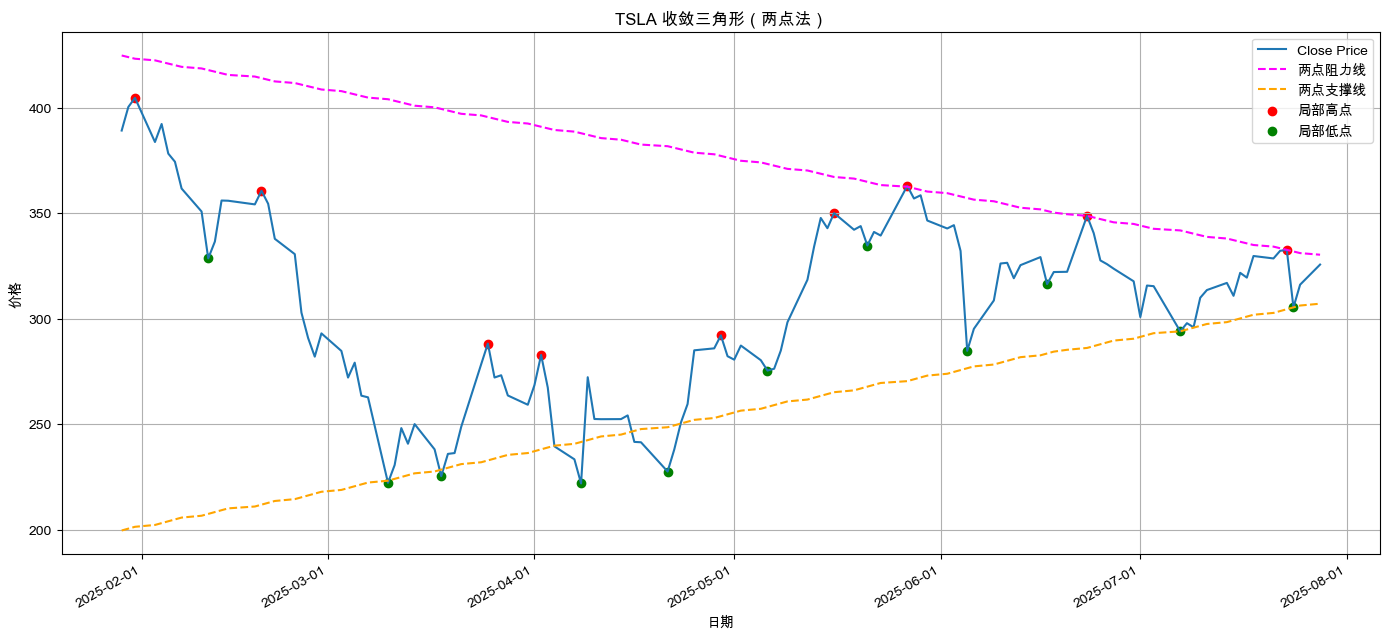

In [29]:
# 使用最后两个高点和低点画出收敛三角形边界线
if len(local_max_idx) >= 2 and len(local_min_idx) >= 2:
    x_max = local_max_idx[-2:]
    y_max = price[x_max]
    x_min = local_min_idx[-2:]
    y_min = price[x_min]

    def line_between(x1, y1, x2, y2, x_vals):
        k = (y2 - y1) / (x2 - x1)
        b = y1 - k * x1
        return k * x_vals + b

    x_all = np.arange(len(df))
    upper_line = line_between(x_max[0], y_max[0], x_max[1], y_max[1], x_all)
    lower_line = line_between(x_min[0], y_min[0], x_min[1], y_min[1], x_all)

    # 绘图
    plt.figure(figsize=(14, 7))
    plt.plot(df['Date'], df['Close'], label='Close Price')
    plt.plot(df['Date'], upper_line, '--', color='magenta', label='两点阻力线')
    plt.plot(df['Date'], lower_line, '--', color='orange', label='两点支撑线')
    plt.scatter(df['Date'].iloc[local_max_idx], price[local_max_idx], color='red', label='局部高点')
    plt.scatter(df['Date'].iloc[local_min_idx], price[local_min_idx], color='green', label='局部低点')
    plt.title(f'{ticker} 收敛三角形（两点法）')
    plt.xlabel('日期')
    plt.ylabel('价格')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gcf().autofmt_xdate()
    plt.show()
else:
    print('⚠️ 极值点不足，无法绘制两点法三角形')

In [30]:
# 🧠 自动判断交点位置、突破方向，并给出策略建议（稳定版）
if len(local_max_idx) >= 2 and len(local_min_idx) >= 2:
    # 最近两个高点和低点
    x_max = local_max_idx[-2:]
    y_max = price[x_max]
    x_min = local_min_idx[-2:]
    y_min = price[x_min]

    # 拟合两点成直线（返回斜率和截距）
    def line_params(x1, y1, x2, y2):
        k = (y2 - y1) / (x2 - x1)
        b = y1 - k * x1
        return float(k), float(b)

    ku, bu = line_params(x_max[0], y_max[0], x_max[1], y_max[1])  # 阻力线
    kl, bl = line_params(x_min[0], y_min[0], x_min[1], y_min[1])  # 支撑线

    # 计算交点（x 轴上）
    if ku != kl:
        x_intersect = float((bl - bu) / (ku - kl))
        y_intersect = float(ku * x_intersect + bu)
        idx_est = int(min(max(x_intersect, 0), len(df) - 1))
        print(f"📍 收敛交点预计出现在第 {x_intersect:.1f} 根K线，价格约 {y_intersect:.2f}")
        print(f"🕒 日期约为：{df['Date'].iloc[idx_est]}")
    else:
        print("⚠️ 两线平行，无交点")

    # 当前价格与上下边界线比较（全部强制转 float）
    current_price = float(df['Close'].iloc[-1])
    x_now = float(len(df) - 1)
    upper_now = float(ku * x_now + bu)
    lower_now = float(kl * x_now + bl)

    print(f"\n📊 当前价格：{current_price:.2f}，上轨：{upper_now:.2f}，下轨：{lower_now:.2f}")

    # 判断突破方向
    if current_price > upper_now:
        print("🚀 当前价格已向上突破三角形")
        print(f"✅ 建议入场做多 @ {current_price:.2f}")
        print(f"🎯 止盈目标：{current_price * 1.1:.2f}")
        print(f"🛑 止损设置：{upper_now * 0.97:.2f}")
    elif current_price < lower_now:
        print("📉 当前价格已向下跌破三角形")
        print(f"✅ 建议入场做空 @ {current_price:.2f}")
        print(f"🎯 止盈目标：{current_price * 0.9:.2f}")
        print(f"🛑 止损设置：{lower_now * 1.03:.2f}")
    else:
        print("⏳ 当前仍处于三角形通道内，建议等待突破")
else:
    print("⚠️ 极值点不足，无法进行策略分析")

📍 收敛交点预计出现在第 137.1 根K线，价格约 319.40
🕒 日期约为：2025-07-28 00:00:00

📊 当前价格：325.59，上轨：330.26，下轨：307.05
⏳ 当前仍处于三角形通道内，建议等待突破


/var/folders/4y/thfdflqj5dq5h4jky3shnl3r0000gn/T/ipykernel_19549/851125698.py:60: PerformanceWarning: indexing past lexsort depth may impact performance.
  axs[2].plot(df[('Date', )], df[('Close', 'TSLA')], label='Close')
/var/folders/4y/thfdflqj5dq5h4jky3shnl3r0000gn/T/ipykernel_19549/851125698.py:61: PerformanceWarning: indexing past lexsort depth may impact performance.
  axs[2].scatter(df[('Date', )][df[('Signal', )] == 1], df[('Close', 'TSLA')][df[('Signal', )] == 1], label='做空', marker='^', color='green')
/var/folders/4y/thfdflqj5dq5h4jky3shnl3r0000gn/T/ipykernel_19549/851125698.py:62: PerformanceWarning: indexing past lexsort depth may impact performance.
  axs[2].scatter(df[('Date', )][df[('Signal', )] == -1], df[('Close', 'TSLA')][df[('Signal', )] == -1], label='做多', marker='v', color='red')


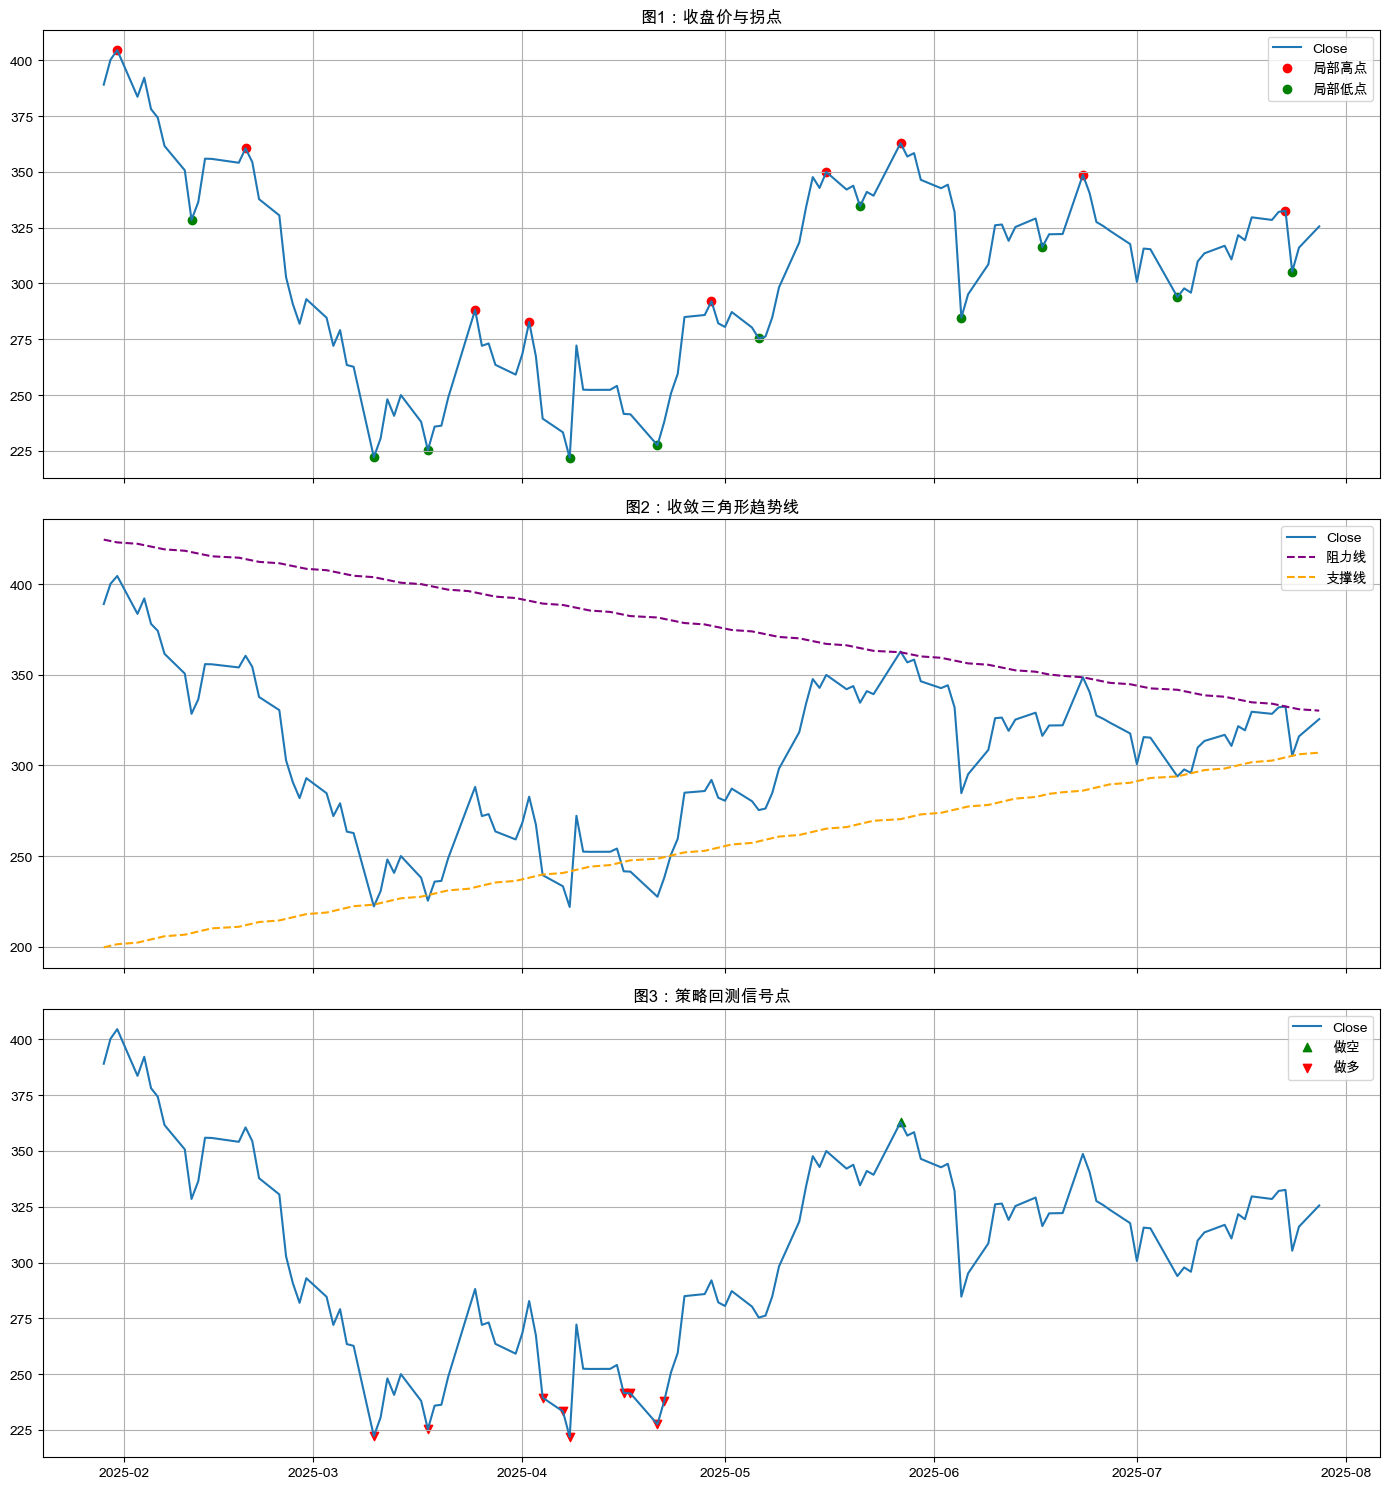

✅ 当前无明确突破信号


In [34]:
# ✅ 多图可视化 + 简易策略回测 + 报警提示
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart

fig, axs = plt.subplots(3, 1, figsize=(14, 15), sharex=True)

# 图1：收盘价 + 局部极值
axs[0].plot(df['Date'], df['Close'], label='Close')
axs[0].scatter(df['Date'].iloc[local_max_idx], price[local_max_idx], color='red', label='局部高点')
axs[0].scatter(df['Date'].iloc[local_min_idx], price[local_min_idx], color='green', label='局部低点')
axs[0].set_title('图1：收盘价与拐点')
axs[0].legend()
axs[0].grid(True)

# 图2：两点趋势线三角形
axs[1].plot(df['Date'], df['Close'], label='Close')
if len(local_max_idx) >= 2 and len(local_min_idx) >= 2:
    x_max = local_max_idx[-2:]
    y_max = price[x_max]
    x_min = local_min_idx[-2:]
    y_min = price[x_min]
    def line_between(x1, y1, x2, y2, x_vals):
        k = (y2 - y1) / (x2 - x1)
        b = y1 - k * x1
        return k * x_vals + b
    x_all = np.arange(len(df))
    upper_line = line_between(x_max[0], y_max[0], x_max[1], y_max[1], x_all)
    lower_line = line_between(x_min[0], y_min[0], x_min[1], y_min[1], x_all)
    axs[1].plot(df['Date'], upper_line, '--', label='阻力线', color='purple')
    axs[1].plot(df['Date'], lower_line, '--', label='支撑线', color='orange')
axs[1].set_title('图2：收敛三角形趋势线')
axs[1].legend()
axs[1].grid(True)

# 图3：策略回测（简单）
# 图3：策略回测（简单）
signal = []
entry_price = None
returns = []
for i in range(len(df)):
    if i < 2 or i >= len(df)-1:
        signal.append(0)
        continue
    price_now = df['Close'].iloc[i] # price_now is a Series here
    up = upper_line[i]
    low = lower_line[i]
    
    # Corrected line: Access the scalar value from the Series
    if price_now.item() > up:  # or price_now.iloc[0] > up:
        signal.append(1)  # 做多
        entry_price = price_now.item() # Also update entry_price with the scalar value
    elif price_now.item() < low: # or price_now.iloc[0] < low:
        signal.append(-1)  # 做空
        entry_price = price_now.item() # Also update entry_price with the scalar value
    else:
        signal.append(0)

df['Signal'] = signal
axs[2].plot(df[('Date', )], df[('Close', 'TSLA')], label='Close')
axs[2].scatter(df[('Date', )][df[('Signal', )] == 1], df[('Close', 'TSLA')][df[('Signal', )] == 1], label='做空', marker='^', color='green')
axs[2].scatter(df[('Date', )][df[('Signal', )] == -1], df[('Close', 'TSLA')][df[('Signal', )] == -1], label='做多', marker='v', color='red')
axs[2].set_title('图3：策略回测信号点')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

# 简易报警提示（可替换为邮箱/telegram）
latest_signal = df['Signal'].iloc[-1]
if latest_signal == 1:
    print('🚨 报警：TSLA 向上突破，建议关注多头机会！')
elif latest_signal == -1:
    print('🚨 报警：TSLA 向下跌破，建议关注空头机会！')
else:
    print('✅ 当前无明确突破信号')

In [32]:
# ✅ 修复回测策略中 Series 比较报错的问题
# 确保 upper_line 和 lower_line 是 numpy 数组
upper_line = np.array(upper_line)
lower_line = np.array(lower_line)

signal = []
for i in range(len(df)):
    if i < 2 or i >= len(df) - 1:
        signal.append(0)
        continue
    price_now = float(df['Close'].iloc[i])
    up = float(upper_line[i])
    low = float(lower_line[i])
    if price_now > up:
        signal.append(1)  # 做多
    elif price_now < low:
        signal.append(-1)  # 做空
    else:
        signal.append(0)

df['Signal'] = signal
print('✅ 策略信号已重新计算并赋值到 df["Signal"]')

✅ 策略信号已重新计算并赋值到 df["Signal"]


In [33]:
# 🧠 自动判断交点位置、突破方向，并给出策略建议（修复所有 float/Series 问题）
if len(local_max_idx) >= 2 and len(local_min_idx) >= 2:
    x_max = local_max_idx[-2:]
    y_max = price[x_max]
    x_min = local_min_idx[-2:]
    y_min = price[x_min]

    def line_params(x1, y1, x2, y2):
        k = (y2 - y1) / (x2 - x1)
        b = y1 - k * x1
        return float(k), float(b)

    ku, bu = line_params(x_max[0], y_max[0], x_max[1], y_max[1])
    kl, bl = line_params(x_min[0], y_min[0], x_min[1], y_min[1])

    if ku != kl:
        x_intersect = float((bl - bu) / (ku - kl))
        y_intersect = float(ku * x_intersect + bu)
        idx_est = int(min(max(x_intersect, 0), len(df) - 1))
        print(f"📍 收敛交点预计出现在第 {x_intersect:.1f} 根K线，价格约 {y_intersect:.2f}")
        print(f"🕒 日期约为：{df['Date'].iloc[idx_est]}")
    else:
        print("⚠️ 两线平行，无交点")

    current_price = float(df['Close'].iloc[-1])
    x_now = len(df) - 1
    upper_now = float(ku * x_now + bu)
    lower_now = float(kl * x_now + bl)

    print(f"\n📊 当前价格：{current_price:.2f}，上轨：{upper_now:.2f}，下轨：{lower_now:.2f}")

    if current_price > upper_now:
        print("🚀 当前价格已向上突破三角形")
        print(f"✅ 建议入场做多 @ {current_price:.2f}")
        print(f"🎯 止盈目标：{current_price * 1.1:.2f}")
        print(f"🛑 止损设置：{upper_now * 0.97:.2f}")
    elif current_price < lower_now:
        print("📉 当前价格已向下跌破三角形")
        print(f"✅ 建议入场做空 @ {current_price:.2f}")
        print(f"🎯 止盈目标：{current_price * 0.9:.2f}")
        print(f"🛑 止损设置：{lower_now * 1.03:.2f}")
    else:
        print("⏳ 当前仍处于三角形通道内，建议等待突破")
else:
    print("⚠️ 极值点不足，无法进行策略分析")

📍 收敛交点预计出现在第 137.1 根K线，价格约 319.40
🕒 日期约为：2025-07-28 00:00:00

📊 当前价格：325.59，上轨：330.26，下轨：307.05
⏳ 当前仍处于三角形通道内，建议等待突破
